In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
end 

┌ Warning: Error requiring `LazyArrays` from `DistributionsAD`
│   exception =
│    LoadError: UndefVarError: ValueSupport not defined
│    Stacktrace:
│      [1] top-level scope
│        @ ~/.julia/packages/DistributionsAD/GGe2E/ext/DistributionsADLazyArraysExt.jl:15
│      [2] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [3] include(x::String)
│        @ DistributionsAD ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1
│      [4] top-level scope
│        @ ~/.julia/packages/Requires/Z8rfN/src/Requires.jl:40
│      [5] eval
│        @ ./boot.jl:368 [inlined]
│      [6] eval
│        @ ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1 [inlined]
│      [7] (::DistributionsAD.var"#398#411")()
│        @ DistributionsAD ~/.julia/packages/Requires/Z8rfN/src/require.jl:101
│      [8] macro expansion
│        @ timing.jl:382 [inlined]
│      [9] err(f::Any, listener::Module, modname::String, file::String, line::Any)
│        @ Require

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

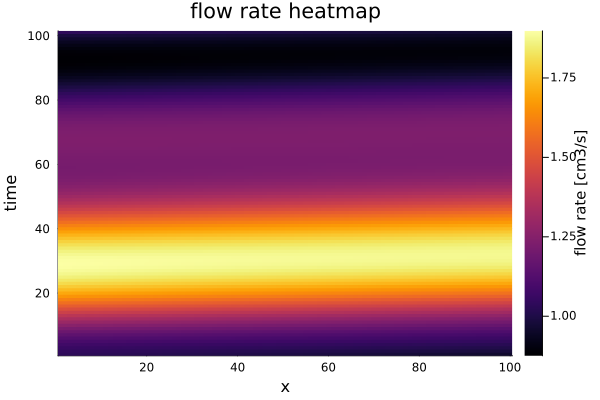

In [5]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


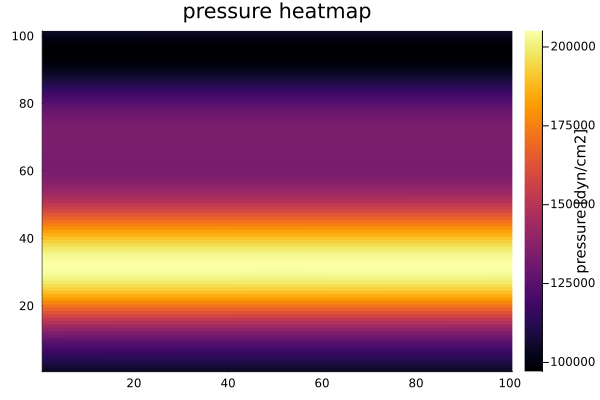

In [6]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [7]:
begin
    global dt = 0.01                     # time step
    global T = 1.0                   # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [8]:
waveforms = 1

1

In [9]:
u0 = data1d_fix[1,:,1:waveforms,1];
u01 = data1d_fix[1,:,1,1];

In [10]:
ytrain2 = data1d_fix[:,:,1:waveforms,1];
ytrain21 = data1d_fix[:,:,1,1];


In [11]:
bc_flow = data1d_fix[:,1,:,1];
bc_flow1 = bc_flow[:,1];

In [12]:
size(ytrain21)

(101, 100)

In [13]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
ann = Chain(
            Dense(N+size(bc_flow1)[1],50,tanh), # extra input for the BC
            Dense(50,50,tanh),
            Dense(50,50,tanh),
            Dense(50,N));

In [14]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 20300


In [15]:
# function learn_1DBlood(u, p, t, bc_left)
#     Φ = re(p) # restructure flattened parameter vector into NN architecture.
#     # Apply boundary conditions
#     u[1] = bc_left(t)
#     return Φ(u)
# end



function learn_1DBlood(u, p, t, bc_left)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    #concatenate u and the BC as input to the NN
    input = vcat(u,bc_left)
    
    return Φ(input)  # Call Φ with modified input
end



learn_1DBlood (generic function with 1 method)

In [16]:
# Define time-dependent boundary conditions
function bc_left(t, bc_flow1)
    # Define the value of the boundary condition at the left boundary for a given time t

    # Find the two closest points in bc_flow1
    #caculate the time index that's closest to time t
    t_index = Int(floor(t / dt)) + 1
    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        bc_interp = bc_flow1[t_index]
        
    else
        bc_interp = (1 - t_frac) * bc_flow1[t_index] + t_frac * bc_flow1[t_index + 1]
    end
    
    return bc_interp
end


# Define time-dependent boundary condition function
bc_left_func(t) = bc_left(t, bc_flow1)

bc_left_func (generic function with 1 method)

In [17]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_left_func), u01, tspan, p)


learn_1DBlood_prob (generic function with 1 method)

In [18]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/paramBC_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(201 => 50, tanh)  # 10_100 parameters
│   summary(x) = "201-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


saved untrained solution


In [19]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow1), u01, tspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
end 

predict (generic function with 1 method)

In [20]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    l = sum(abs2,(pred[:,:] - ytrain21))#  + 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [21]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [22]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [23]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [24]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


time: 1/1
Start training epoch 1
Using ADAM optimizer
Sum of params:-1.7982154
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 996.7378033382295
Iteration: 2 || Loss: 1447.6995556803859
Iteration: 3 || Loss: 1059.7875671944917
Iteration: 4 || Loss: 911.2484302935419
Iteration: 5 || Loss: 812.9463912821375
Iteration: 6 || Loss: 812.9463912821375
saving ADAM checkpoint...
Sum of params:5.6289635
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 812.9463912821375
Iteration: 2 || Loss: 782.0796616111935
Iteration: 3 || Loss: 701.5755703401668
Iteration: 4 || Loss: 677.1526096603104
Iteration: 5 || Loss: 659.9773909798888
Iteration: 6 || Loss: 648.9146527599769
Iteration: 7 || Loss: 642.1943057843993
Iteration: 8 || Loss: 637.8032394447566
Iteration: 9 || Loss: 634.4277956950567
Iteration: 10 || Loss: 632.7181826352426
Iteration: 11 || Loss: 632.3179629356212
Iteration: 12 || Loss: 632.0885574199231
Iteration: 13 || Loss: 632.0226152600709
It

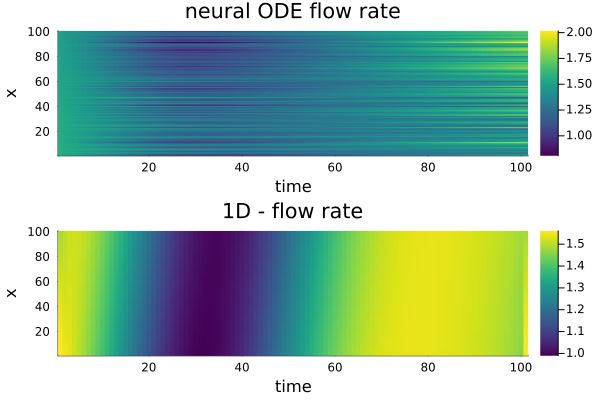

Start training epoch 2
Using ADAM optimizer
Sum of params:72.37368
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 206.23766208604115
Iteration: 2 || Loss: 2221.0232082289676
Iteration: 3 || Loss: 357.13747062658473
Iteration: 4 || Loss: 770.9961850580306
Iteration: 5 || Loss: 769.3626451477656
Iteration: 6 || Loss: 206.23766208604115
saving ADAM checkpoint...
Sum of params:72.37368
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 206.23766208604115
Iteration: 2 || Loss: 204.4930441090568
Iteration: 3 || Loss: 199.77091870616067
Iteration: 4 || Loss: 192.28778675607677
Iteration: 5 || Loss: 186.39425271682194
Iteration: 6 || Loss: 179.62065269720003
Iteration: 7 || Loss: 173.39840747642532
Iteration: 8 || Loss: 159.22089848946268
Iteration: 9 || Loss: 142.23285013428503
Iteration: 10 || Loss: 133.4078658717314
Iteration: 11 || Loss: 107.38870005645389
Iteration: 12 || Loss: 103.03627898118009
Iteration: 13 || Loss: 79.27205931725776
Ite

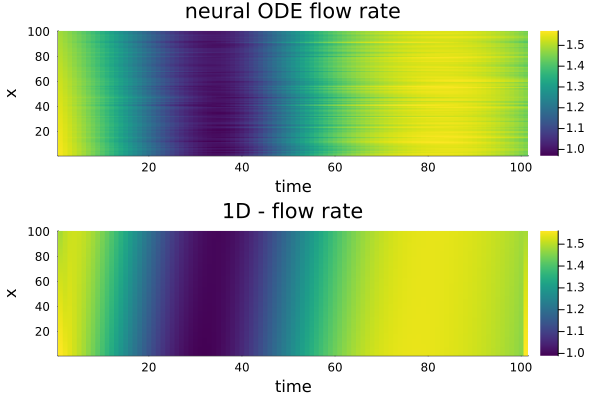

Start training epoch 3
Using ADAM optimizer
Sum of params:66.65697
Changing learning rate to:0.0001
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 7.830349792100928
Iteration: 2 || Loss: 114.30252351111396
Iteration: 3 || Loss: 15.243406259423509
Iteration: 4 || Loss: 33.709190594604095
Iteration: 5 || Loss: 55.32419300934638
Iteration: 6 || Loss: 7.830349792100928
saving ADAM checkpoint...
Sum of params:66.65697
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 7.830349792100928
Iteration: 2 || Loss: 7.828661513323091
Iteration: 3 || Loss: 7.828655647905536
Iteration: 4 || Loss: 7.799718718533122
Iteration: 5 || Loss: 7.792402858041418
Iteration: 6 || Loss: 7.664476673660538
Iteration: 7 || Loss: 7.585561580345324
Iteration: 8 || Loss: 7.48325281247182
Iteration: 9 || Loss: 7.391033108684631
Iteration: 10 || Loss: 7.311676117318833
Iteration: 11 || Loss: 7.24056069564962
Iteration: 12 || Loss: 7.09588924337139
Iteration: 13 || Loss: 6.

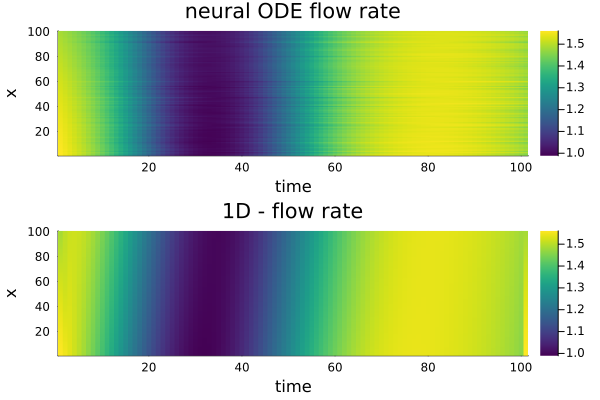

Start training epoch 4
Using ADAM optimizer
Sum of params:62.995354
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 4.167516491064746
Iteration: 2 || Loss: 21.47791235677699
Iteration: 3 || Loss: 5.255948561785905
Iteration: 4 || Loss: 10.086535681745852
Iteration: 5 || Loss: 13.960969216388495
Iteration: 6 || Loss: 4.167516491064746
saving ADAM checkpoint...
Sum of params:62.995354
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 4.167516491064746
Iteration: 2 || Loss: 4.162044865058807
Iteration: 3 || Loss: 4.1600880341545405
Iteration: 4 || Loss: 4.158034978379613
Iteration: 5 || Loss: 4.149819869721011
Iteration: 6 || Loss: 4.138187455843129
Iteration: 7 || Loss: 4.120791294068932
Iteration: 8 || Loss: 4.104761205237791
Iteration: 9 || Loss: 4.095489216535667
Iteration: 10 || Loss: 4.083063261353436
Iteration: 11 || Loss: 4.062271620479379
Iteration: 12 || Loss: 4.043579842665929
Iteration: 13 || Loss: 4.009744837058081
Iteration: 1

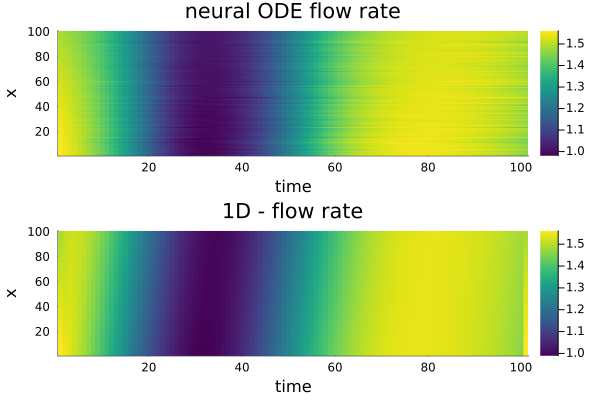

Start training epoch 5
Using ADAM optimizer
Sum of params:60.711643
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 3.241087482168278
Iteration: 2 || Loss: 7.145047999987454
Iteration: 3 || Loss: 5.486662702569081
Iteration: 4 || Loss: 3.6478891097174193
Iteration: 5 || Loss: 5.226033917460614
Iteration: 6 || Loss: 3.241087482168278
saving ADAM checkpoint...
Sum of params:60.711643
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 3.241087482168278
Iteration: 2 || Loss: 3.2389481231375363
Iteration: 3 || Loss: 3.2387587223498318
Iteration: 4 || Loss: 3.2387587223498318
Iteration: 5 || Loss: 3.2387587223498318
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:60.711845
Epoch 5 loss:3.2387587223498318


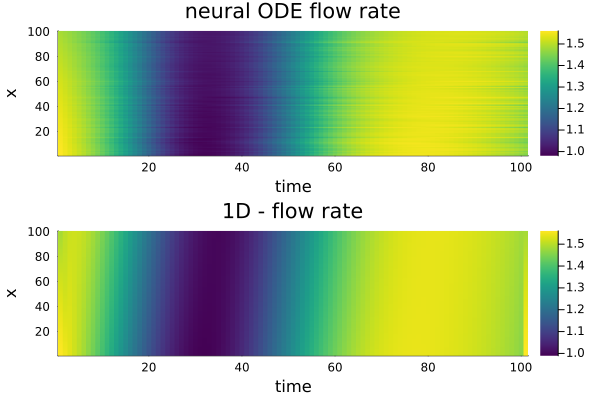

Initial Condition 1mean loss loss:22.471537457372495


In [25]:

n_epochs = 5

#set time horizon settings
nt = 100
n_samples = Int(100/nt)+1

list_loss_train = []
# loop over different waveforms
for i in 1:size(ytrain2,3)
    
    #initialize loss
    loss_tot = 0.0
    
    # time horizon loop
    for k in 2:n_samples
        println("time: ",k-1, "/",n_samples-1)
        
        # epochs loop
        for j in 1:n_epochs
            println("Start training epoch ",j)

            T = dt * nt  # total time
            tspan = (0.0, T)
            tsteps = 0:dt:tspan[2]  # create time vector
            
            #define BC only on the time horizon that is active, zero otherwise
            bcflow_k = zero(bc_flow1)
            bcflow_k[(k-2)*nt+1:(k-1)*nt+1] = bc_flow[(k-2)*nt+1:(k-1)*nt+1,i]
            
            #define optimization problem
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);

            optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob),adtype) ;

            println("Using $optimizer_choice1 optimizer")
            println("Sum of params:", sum(uinit))
            
            # Change learning rate for ADAM optimizer, BFGS doesn't use it
            if j == 3
                learning_rate = 0.0001
                println("Changing learning rate to:",learning_rate)
            end
            
            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
            println("Sum of params:", sum(uinit))
            
            if !isnothing(optimizer_choice2)
                println("Switching to $optimizer_choice2 optimizer")

                uinit = train_loop(uinit,adtype,optf,train_maxiters*10,learning_rate,optimizer_choice2)

                println("Sum of params:", sum(uinit))

            end
            
            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t,bcflow_k), ytrain2[(k-2)*nt+1,:,i], tspan, p);
            l , pred = loss(uinit,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob)
            loss_tot = loss_tot + l
            
            push!(list_loss_train, l)
            println("Epoch ", j, " loss:", l)
            
            
            # plot solution for comparison
            plot1 = heatmap(pred[:,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]', title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end
    end
    println("Initial Condition ", i, "mean loss loss:", loss_tot/(n_epochs*n_samples))
end


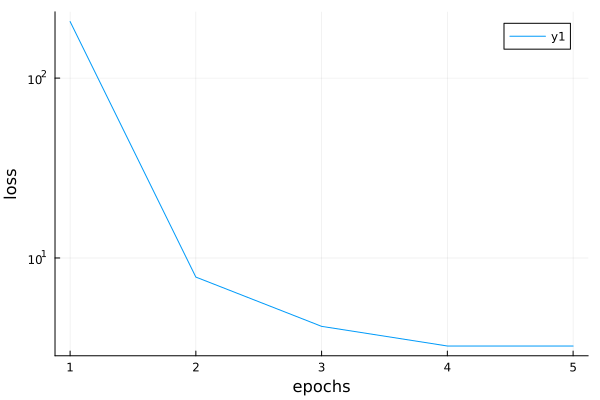

In [28]:
# plot loss as a function of epochs
plot(list_loss_train, yaxis=:log)
ylabel!("loss")
xlabel!("epochs")

### Load the final learnt parameters and do inference ###

In [141]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

In [142]:
# p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [126]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

0.0:0.01:0.1

In [131]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

t:0.01
1512.8225980434204
saved trained solution
Loss: 1.3094590686431937
t:0.11
1499.0022035988716
saved trained solution
Loss: 45.88995970107579
t:0.21
1485.1817717310107
saved trained solution
Loss: 166.03289571339414
t:0.31
1471.3613010710685
saved trained solution
Loss: 201.69458180677182
t:0.41000000000000003
1457.5407821061353
saved trained solution
Loss: 100.65537789230933
t:0.51
1443.7202121595947
saved trained solution
Loss: 14.399602998020736
t:0.61
1429.8995878709964
saved trained solution
Loss: 5.772021530560427
t:0.71
1416.0789001858166
saved trained solution
Loss: 18.408064093324786
t:0.81
1402.2581533817172
saved trained solution
Loss: 21.566439159871727
t:0.91
1388.4373405339297
saved trained solution
Loss: 16.13946028735416


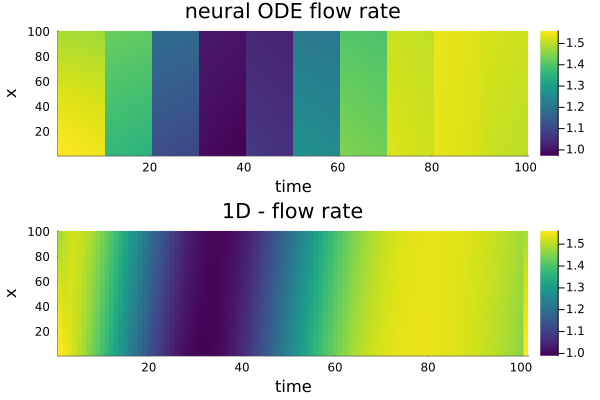

In [130]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))